# Step 1. 형태소 분석기 변경해 보기

In [1]:
# 최종적으로 [뉴스제목, 분류] 데이터 프레임 생성 :
# make_total_data(페이지까지, code_list, 날짜)

import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [2]:
# 뉴스 제목, 분류 인스턴트 생성
# df = make_total_data(1, code_list, 20231128)

# 1. 원하는 코드리스트 결정
code_list = [102, 103, 105]

# 2. 인스턴트 생성
df = make_total_data(1, code_list, 20231128)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [3]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data.csv File Saved!


In [4]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,돈가스 3kg으로 85명 원생 배식한 어린이집 원장 재판行,사회
1,[뉴스특보 LIVE] 2030 엑스포 개최지 발표 “부산의 도전”,사회
2,동명이인 환자 명의로 '의료용 마약류' 처방받은 의사,사회
3,"""만원의 가치, 만원의 효용을 체감하는 기자협회""",사회
4,"""2024년 힘차고 따뜻한 기자협회 원년""",사회


In [5]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_142/3649439000.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0                    돈가스 으로 명 원생 배식한 어린이집 원장 재판
1                      뉴스특보   엑스포 개최지 발표 부산의 도전
2                   동명이인 환자 명의로 의료용 마약류 처방받은 의사
3                      만원의 가치 만원의 효용을 체감하는 기자협회
4                             년 힘차고 따뜻한 기자협회 원년
5                     세계일보 사건팀 장애인본부 이달의 좋은 기사상
6                       나에게 우리에게 세상에 쓸모 있는 기자협회
7                 유튜버 일탈 어디까지모텔서 수면제 투약하고 방송한 대
8                        해마루촌 마을주민 동서대에 감사패쌀 전달
9                      강릉시 옥계면연곡면 일대 지적재조사사업 추진
10                   횡성 디피코 사모펀드 운용사와 조건부 투자 계약
11                    핵심 비전 소개하는 나승연 부산엑스포 홍보대사
12                        평창 국제올림픽 연구센터 컨퍼런스 개막
13                   우리 부산은요핵심 비전 소개하는 나승연 홍보대사
14         며느리 살해한 시아버지 아들 내외가 나 죽이려 했다피해 망상 추정
15    전쟁 폐허 극복한 부산의 저력 공유 연대의 엑스포 역설 엑스포 개최지 선정
16                채팅앱서 만난 또래 여학생 살해한 대 남학생 구속기소
17                      동해 묵호항 항만대기질 관리구역 지정 요구
18                     강릉 급발진 의심사고 민사소송 변론기일 열려
19                           포토  장애인 먼저 실천상 시상식
20    조수미이정재싸이 엑스포  등장공존의 도시 부산에 오세요 엑스포

In [6]:
# Null 값 확인
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [7]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  58


<AxesSubplot:>

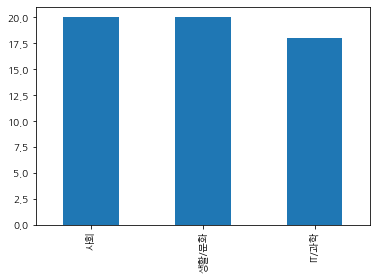

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [9]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     18
1     사회     20
2  생활/문화     20


In [10]:
from konlpy.tag import Mecab
from konlpy.tag import Hannanum


tokenizer = Mecab()
tokenizer2 = Hannanum()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.

print(tokenizer.morphs(kor_text))
print(tokenizer2.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']
['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속됐다서울', '제주경찰', '서는', '상하', '어', '혐의', '로', '씨', '를', '구속해', '수사', '하고', '있', '다', '고', '일', '밝혔다씨', '는', '지난달', '일', '피하', '어', '여성', '을', '인근', '지하철', '역', '에서부터', '따르', '아', '가', '아', '폭행', '을', '시도', '하', '려', '다가', '도망가', 'ㄴ', '혐의', '를', '받는다피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '아며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰',

In [11]:
# 불용어 지정
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [12]:
# Mecab과 Hannanum 토크나이져의 연산 속도를 비교하는 결과도 출력합니다.

import time

def preprocessing_comp(data): # Mecab과 Hannanum 토크나이져를 포함한 함수
  text_data = []
  text_data2 = []  
  
  start = time.time()   # 시작1
  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)
  print("Mecab 소요시간 :", time.time() - start)   # 종료1

  text_data = list(map(' '.join, text_data))
    
  start = time.time()    # 시작2
  for sentence in data:
    temp_data2 = []
    #- 토큰화
    temp_data2 = tokenizer2.morphs(sentence) 
    #- 불용어 제거
    temp_data2 = [word for word in temp_data2 if not word in stopwords] 
    text_data2.append(temp_data2)

  text_data2 = list(map(' '.join, text_data2))
  print("Hannanum 소요시간 :", time.time() - start)   # 종료2
    
  return text_data, text_data2

In [13]:
text_data, text_data2 = preprocessing_comp(df['news'])

print(text_data[0])
print(text_data2[0])

Mecab 소요시간 : 0.012778997421264648
Hannanum 소요시간 : 0.6596012115478516
돈가스 으로 명 원생 배식 어린이집 원장 재판
돈가스 으 로 명 원생 배식 ㄴ 어린이집 원장 재판


Step 1. 형태소 분석기 변경해 보기 Conclusion

1. Mecab 이 Hannanum 보다 약 50~60배 빠르게 테스크를 처리하였다
2. 두 토크나이져는 명칭과 외래어 이름을 분류하는데 각기 문제가 있다. 예를 들면 Mecab 은 카이스트, 유니스트를 '카 이스트,' '유 니스트,' 로 토큰화하며, Hannanum 의 경우에는 '물망유니스트,'될까당뇨' 등으로 명사를 잘못 토큰화하는 결과를 보였다.
3. Hannanum 은 Mecab 와 달리 'ㄴ'과 같이 동사와 형용사를 구분하기에 더 많은 수행 시간이 걸린 것으로 생각된다.
4. 두 토크나이져 모두 명사를 처리하는데 문제를 보이지만 속도를 우선시 한다면 Hannanum 보다 Mecab 을 선택하는 것이 좋아 보인다.

# Step 2. 불용어 추가해 보기

In [60]:
# 기존 Stopwords 에 추가하기 
# '유', '니스트', '카', '이스트', 횡', '성', '년', '려' 추가

stopwords_2 = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '유', '니스트', '이스트', '카', '횡', '성', '년', '려']

In [61]:
# 다음 루브릭을 수행하기 위해 토크나이져를 Mecab 으로만 설정한 함수 preprocessing_2
 
def preprocessing_2(data):
  text_data = [] 
  
  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- stopwords_2의 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords_2] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))
    
  return text_data

In [62]:
text_data = preprocessing_2(df['news'])

In [91]:
text_data

['돈가스 으로 명 원생 배식 어린이집 원장 재판',
 '특보 엑스포 개최지 발표 부산 도전',
 '동명이인 환자 명의 로 의료 용 마약 류 처방 받 의사',
 '만 원 가치 만 원 효용 체감 협회',
 '힘차 고 따뜻 협회 원년',
 '세계일보 사건 팀 장애 인 본부 이달 좋 기사 상',
 '나 우리 세상 쓸모 협회',
 '튜버 일탈 어디 까지 모텔 서 수면제 투약 고 방송 대',
 '해마루 촌 마을 주민 동서대 감사패 쌀 전달',
 '강릉시 옥계면 연곡면 일대 지적 재조사 사업 추진',
 '디피 코 사모 펀드 운용 사 와 조건부 투자 계약',
 '핵심 비전 소개 나승연 부산 엑스포 홍보 대사',
 '평창 국제 올림픽 연구 센터 컨퍼런스 개막',
 '우리 부산 요 핵심 비전 소개 나승연 홍보 대사',
 '며느리 살해 시아버지 아들 내외 나 죽이 피해 망상 추정',
 '전쟁 폐허 극복 부산 저력 공유 연대 엑스포 역설 엑스포 개최지 선정',
 '채팅 앱 서 만난 또래 여학생 살해 대 남학생 구속 기소',
 '동해 묵호항 항만 대기 질 관리 구역 지정 요구',
 '강릉 급발진 의심 사고 민사 소송 변론 기일 열려',
 '포토 장애 인 먼저 실천 상 시상식',
 '조수미 이정재 싸이 엑스포 장공 존 도시 부산 오 세요 엑스포 개최지 발표',
 '강 스템 바이오 텍 퓨어 스템 오에이 키트 주 임상 순항 기술 수출 최선',
 '가짜 환자 지만 정신 병원 입원 성공 습니다',
 '베를린 필하모닉 준비 진은숙 에디션 발매',
 '가장 아름다운 비밀 쓰 지 않 아요',
 '여성 영화 인 축제 올해 여성 영화 인상 시상식 월일 개최',
 '외국 즐기 한국 잘 해야 만 한다 현대 사회 에서 평화 찾 이곳',
 '엄마 우리 집 채소 왜 얼 어 어 싸 니까 냉 동식 재료 인기 라는 데',
 '조선 자유 언론 수호 투쟁 위원회 엮음',
 '동아제약 중대 재해 대응 모의 훈련 실시 심폐 소생 술 교육',
 '휴 젤 여성 소비자 뽑 좋 기업 대상 연속 수상',
 '울산 오늘 낮 최고 

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

훈련용 뉴스 기사의 개수 : 43
테스트용 뉴스 기사의 개수 :  15
훈련용 레이블의 개수 :  43
테스트용 레이블의 개수 :  15
              precision    recall  f1-score   support

       IT/과학       1.00      0.25      0.40         4
          사회       0.31      1.00      0.47         4
       생활/문화       1.00      0.14      0.25         7

    accuracy                           0.40        15
   macro avg       0.77      0.46      0.37        15
weighted avg       0.82      0.40      0.35        15



Step 2. 불용어 추가해 보기 Conclusion

1. 새로 추가한 불용어 ['유', '니스트', '카', '이스트', 횡', '성', '년', '려'] 가 잘 지워졌다.
2. 평균 f1-score 0.40 결과가 나왔다.    

# Step 3. 다른 날짜 데이터 추가해 보기

In [68]:
# 이중 for 문으로 date 기준 전후 2일을 추가한 뉴스 생성

def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
        for j in range(date - 2, date + 3): # 날짜 추가
          url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(j)+'&page='+str(i)
          headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
          news = requests.get(url, headers=headers)

          # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
          soup = BeautifulSoup(news.content, 'html.parser')

          # CASE 1
          news_list = soup.select('.newsflash_body .type06_headline li dl')
          # CASE 2
          news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
          # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
          for line in news_list:
            urllist.append(line.a.get('href'))
  return urllist

idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [70]:
# 1. 원하는 코드리스트 결정
code_list = [102, 103, 105]

# 2. 2023-11-26 부터 2023-11-30 까지 뉴스 생성
df2 = make_total_data(1, code_list, 20231128)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [71]:
# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path2 = os.getenv("HOME") + "/aiffel/news_crawler/news_data2.csv"
df2.to_csv(csv_path2, index=False)

if os.path.exists(csv_path2):
  print('{} File Saved!'.format(csv_path2))

/aiffel/aiffel/news_crawler/news_data2.csv File Saved!


In [73]:
df2 = pd.read_table(csv_path2, sep=',')
print(df2.head())
print(df2.shape)

                                           news code
0             중부내륙고속도로 문경새재 나들목 인근 차량 운반 화물차 화재   사회
1     인천 영종 골든테라시티 개발사업 앵커 역할할 명문 국제학교 유치 관심 집중   사회
2                      경남 합천 황매산서 50대 남성 추락해 사망   사회
3       권도형 송환 어디로?…몬테네그로 법무, "미국은 대외정책 중심 파트너"   사회
4  “남자 경험 있어?” 구치소서 동성 성관계 제안…거부하자 폭행한 40대男 징역형   사회
(300, 2)


In [74]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df2['news'] = df2['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df2['news']

/tmp/ipykernel_142/2402662495.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['news'] = df2['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0              중부내륙고속도로 문경새재 나들목 인근 차량 운반 화물차 화재
1      인천 영종 골든테라시티 개발사업 앵커 역할할 명문 국제학교 유치 관심 집중
2                         경남 합천 황매산서 대 남성 추락해 사망
3             권도형 송환 어디로몬테네그로 법무 미국은 대외정책 중심 파트너
4          남자 경험 있어 구치소서 동성 성관계 제안거부하자 폭행한 대 징역형
                         ...                    
295                            카카오페이 핀테크 페이민트 인수
296                과기정통부 천억원 규모 반도체 첨단 패키징 사업 추진
297                         우주항공도시 일정대로연말 밑그림 공개
298                    와 유저가 콘텐츠 만든다아프리카 숏폼 경쟁력은
299                    연산 는 상시 품절엔비디아만 웃는다  빅뱅 년
Name: news, Length: 300, dtype: object

In [75]:
# Null 값 확인
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [77]:
# 중복된 샘플들을 제거합니다.
df2.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df2))

뉴스 기사의 개수:  277


<AxesSubplot:>

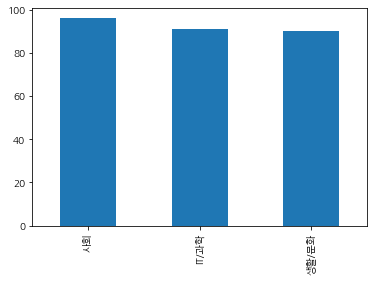

In [78]:
df2['code'].value_counts().plot(kind = 'bar')

In [79]:
print(df2.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     91
1     사회     96
2  생활/문화     90


In [80]:
text_data_multi = preprocessing_2(df2['news'])

In [93]:
text_data_multi

['중부 내륙 고속도 로 문경새재 나들목 인근 차량 운반 화물차 화재',
 '인천 영종 골든 테라 시티 개발 사업 앵커 역할 명문 국제 학교 유치 관심 집중',
 '경남 합천 황매산 서 대 남성 추락 해 사망',
 '권도형 송환 어디 로 몬테네그로 법무 미국 대외 정책 중심 파트너',
 '남자 경험 어 구치 소서 동성 관계 제안 거부 자 폭행 대 징역형',
 '중부 내륙 고속도 로 달리 던 화물차 화재 싣 고 던 차량 그을려',
 '광진구 어두운 뚝 도 변전 소구 역 골목 보안등 추가 설치',
 '경남 합천 황매산 서 대 남성 산객 추락사',
 '금천 연말 까지 치아 튼튼 교실 초등 생 여명 구강 보건 교육',
 '취약 계층 추위 떨 지 않 게 송파구 한파 종합 대책 추진',
 '경복궁 나 추워도 포기 못 해',
 '의협 논의 끝 의대 증원 반대 증원 강행 시 파업 찬반 투표',
 '네 인생 도 망가뜨려 줄게 감독관 위협 학부모 스타 강사 였',
 '담배 피우 려다 전동 휠체어 불대 도 화상',
 '북 콘서트 연 송영길 전 민주당 대표',
 '휠체어 탄 지체 장애 인 담뱃불 붙이 불나 중상',
 '담배 피우 려다 라이터 불 전동 휠체어 붙 어 대 도화 상',
 '알림 신춘문예 응모 요령',
 '엄마 욕했 다며 쇠망치 로 살림살이 깨부순 대',
 '기어 놓 고 통행권 뽑 으려던 대 운전자 끼여 숨졌 사건 수첩',
 '용인 서 도로변 누워 던 주취 자 명 승용차 깔려 다쳐',
 '이선균 마약 제공 혐의 의사 영장 기각 경찰 수사 난항',
 '휠 만 남 바퀴 로 달렸 만취 운전자 위험 천만 도 주',
 '경찰 팔 출신 대학 생 명 총격 대 백 인 남성 체포',
 '기피 일자리 외국 인력 내년 만 천 명 최대',
 '인천 기계식 지하 주차장 서 작업자 명 추락 해 부상',
 '방 성환 경기도 의원 법 조례 부재 상황 에서 농어민 기회 소득 예산 편성 절차 정당 부족',
 '내년 신규 외국인 근로자 만 천 명 역대 최대식 당서 도 일 해',
 '사법 농단 임종헌 징역 

In [90]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data_multi, df2['code'], random_state = 0)

print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

훈련용 뉴스 기사의 개수 : 207
테스트용 뉴스 기사의 개수 :  70
훈련용 레이블의 개수 :  207
테스트용 레이블의 개수 :  70
              precision    recall  f1-score   support

       IT/과학       0.77      0.63      0.69        27
          사회       0.46      0.59      0.52        22
       생활/문화       0.50      0.48      0.49        21

    accuracy                           0.57        70
   macro avg       0.58      0.57      0.57        70
weighted avg       0.59      0.57      0.58        70



Step 3. 다른 날짜 데이터 추가해 보기 Conclusion

1. 2023-11-26 부터 2023-11-30 까지 데이터를 통해 분류해보았다.
2. 평균 f1-score 0.57 로 step2 의 0.40 보다 향상되었다.

# 최종 회고

크롤링이 익숙하지 않았는데 앞으로 반복해서 보면 더 잘 할 수 있을 것 같다.